<a href="https://colab.research.google.com/github/SidtheKidx/music-genre-prediction/blob/main/Thrasio_music_genre_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Music genre prediction - classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import metrics


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, roc_auc_score, auc, f1_score, accuracy_score, confusion_matrix
from xgboost import plot_importance
from scipy import interp


In [2]:
music = pd.read_csv('https://raw.githubusercontent.com/SidtheKidx/music-genre-prediction/main/music_genre.csv')

In [3]:
music.head(10)

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.792000,A#,0.1150,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.950000,D,0.1240,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.011800,G#,0.5340,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.002530,C#,0.1570,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.909000,F#,0.1570,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
5,89064.0,Axel Boman,Hello,47.0,0.00523,0.755,519468.0,0.731,0.854000,D,0.2160,-10.517,Minor,0.0412,?,4-Apr,0.614,Electronic
6,43760.0,Jordan Comolli,Clash,46.0,0.02890,0.572,214408.0,0.803,0.000008,B,0.1060,-4.294,Major,0.3510,149.995,4-Apr,0.230,Electronic
7,30738.0,Hraach,Delirio,43.0,0.02970,0.809,416132.0,0.706,0.903000,G,0.0635,-9.339,Minor,0.0484,120.008,4-Apr,0.761,Electronic
8,84950.0,Kayzo,NEVER ALONE,39.0,0.00299,0.509,292800.0,0.921,0.000276,F,0.1780,-3.175,Minor,0.2680,149.94799999999998,4-Apr,0.273,Electronic
9,56950.0,Shlump,Lazer Beam,22.0,0.00934,0.578,204800.0,0.731,0.011200,A,0.1110,-7.091,Minor,0.1730,139.933,4-Apr,0.203,Electronic


### EDA and feature engineering

In [4]:
music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

In [5]:
music.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,valence
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,55888.396360,44.220420,0.306383,0.558241,2.212526e+05,0.599755,0.181601,0.193896,-9.133761,0.093586,0.456264
std,20725.256253,15.542008,0.341340,0.178632,1.286720e+05,0.264559,0.325409,0.161637,6.162990,0.101373,0.247119
min,20002.000000,0.000000,0.000000,0.059600,-1.000000e+00,0.000792,0.000000,0.009670,-47.046000,0.022300,0.000000
25%,37973.500000,34.000000,0.020000,0.442000,1.748000e+05,0.433000,0.000000,0.096900,-10.860000,0.036100,0.257000
50%,55913.500000,45.000000,0.144000,0.568000,2.192810e+05,0.643000,0.000158,0.126000,-7.276500,0.048900,0.448000
75%,73863.250000,56.000000,0.552000,0.687000,2.686122e+05,0.815000,0.155000,0.244000,-5.173000,0.098525,0.648000
max,91759.000000,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,0.992000


In [6]:
music.shape

(50005, 18)

In [7]:
music['music_genre'].unique()

array(['Electronic', 'Anime', nan, 'Jazz', 'Alternative', 'Country',
       'Rap', 'Blues', 'Rock', 'Classical', 'Hip-Hop'], dtype=object)

In [8]:
music['music_genre'].value_counts()

Alternative    5000
Electronic     5000
Hip-Hop        5000
Classical      5000
Blues          5000
Rap            5000
Rock           5000
Country        5000
Anime          5000
Jazz           5000
Name: music_genre, dtype: int64

In [9]:
#Dropping values that are NANs(i.e. 5 values in 'music genre')
music = music[music['music_genre'].notna()]

In [10]:
genres = music['music_genre'].unique()

In [11]:
music['music_genre'].isnull().sum()

0

In [12]:
music['music_genre'].unique()

array(['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap',
       'Blues', 'Rock', 'Classical', 'Hip-Hop'], dtype=object)

In [13]:
music.dtypes

instance_id         float64
artist_name          object
track_name           object
popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo                object
obtained_date        object
valence             float64
music_genre          object
dtype: object

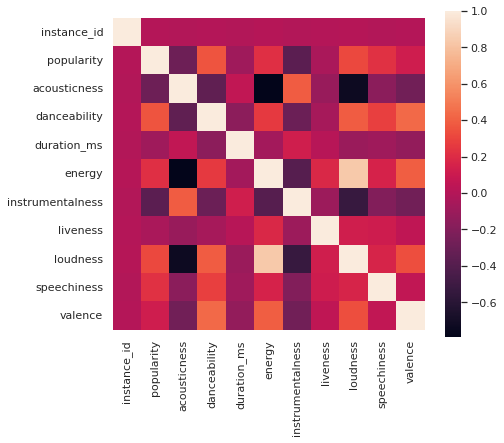

In [14]:
#Finding correlation between features
corrmat = music.corr()
f, ax = plt.subplots(figsize=(7,6))
sns.heatmap(corrmat, square = True)

Right off the bat, we can see:
1. *loudness* and *energy* are **medium-high correlated**. 
2. Followed by **medium correlation**:
*   *loudness*  and *valence*
*   *instrumentalness* and *acousticness* 
*   *loudness* and *danceability* 
*   *energy* and *valence*
*   *danceability* and *valence* 
*   *popularity* and *danceability*




Feature Selection here does not involve dropping one of loudness/energy as it has no effect on predicted results

In [15]:
music.index.is_unique

True

In [16]:
music.drop_duplicates(inplace=True)

In [17]:
music.sort_index()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,58878.0,BEXEY,GO GETTA,59.0,0.03340,0.913,-1.0,0.574,0.00000,C#,0.119,-7.022,Major,0.2980,98.02799999999999,4-Apr,0.330,Hip-Hop
50001,43557.0,Roy Woods,Drama (feat. Drake),72.0,0.15700,0.709,251860.0,0.362,0.00000,B,0.109,-9.814,Major,0.0550,122.04299999999999,4-Apr,0.113,Hip-Hop
50002,39767.0,Berner,Lovin' Me (feat. Smiggz),51.0,0.00597,0.693,189483.0,0.763,0.00000,D,0.143,-5.443,Major,0.1460,131.079,4-Apr,0.395,Hip-Hop
50003,57944.0,The-Dream,Shawty Is Da Shit,65.0,0.08310,0.782,262773.0,0.472,0.00000,G,0.106,-5.016,Minor,0.0441,75.88600000000001,4-Apr,0.354,Hip-Hop


In [18]:
music.head(-10)

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.792000,A#,0.1150,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.950000,D,0.1240,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.011800,G#,0.5340,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.002530,C#,0.1570,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.909000,F#,0.1570,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49990,32849.0,Jeremih,Planez,73.0,0.67400,0.650,240320.0,0.557,0.000000,C#,0.1100,-7.762,Major,0.3120,129.285,4-Apr,0.400,Hip-Hop
49991,40401.0,empty_field,For Real,53.0,0.00392,0.770,211820.0,0.905,0.000003,F,0.1690,-8.235,Minor,0.1440,135.999,4-Apr,0.464,Hip-Hop
49992,67111.0,Ghostemane,Hades,55.0,0.03910,0.829,127128.0,0.590,0.010700,A,0.1140,-7.818,Minor,0.2630,112.97,4-Apr,0.332,Hip-Hop
49993,37756.0,Lecrae,Cry For You,54.0,0.30400,0.642,263467.0,0.353,0.000000,A#,0.0927,-12.384,Minor,0.2150,89.596,4-Apr,0.276,Hip-Hop


In [19]:
music.isnull().sum()

instance_id         0
artist_name         0
track_name          0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
obtained_date       0
valence             0
music_genre         0
dtype: int64

### Encoding categorical data

In [20]:
# replace ? as np.nan in tempo and -1 duration_ms
music['tempo'].replace(to_replace = '?', value =np.nan, inplace=True)
music['duration_ms'].replace(to_replace = -1, value =np.nan, inplace=True)

In [21]:
music.isnull().sum()

instance_id            0
artist_name            0
track_name             0
popularity             0
acousticness           0
danceability           0
duration_ms         4939
energy                 0
instrumentalness       0
key                    0
liveness               0
loudness               0
mode                   0
speechiness            0
tempo               4980
obtained_date          0
valence                0
music_genre            0
dtype: int64

In [22]:
music.fillna(0,inplace=True)

In [23]:
#OP is using a one hot encoder so the fit function won't work with the array @Ishant Mrinal recommends this Y_train = np.argmax(Y_train, axis=1)

# separate into input and output columns
X = pd.DataFrame(music.iloc[:, :-1])
y = pd.DataFrame(music.iloc[:, -1])


In [24]:
y

,music_genre
0,Electronic
1,Electronic
2,Electronic
3,Electronic
4,Electronic
...,...
50000,Hip-Hop
50001,Hip-Hop
50002,Hip-Hop
50003,Hip-Hop


In [25]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
from sklearn import preprocessing
y['genre_Category'] = labelencoder.fit_transform(y['music_genre'])
y

,music_genre,genre_Category
0,Electronic,5
1,Electronic,5
2,Electronic,5
3,Electronic,5
4,Electronic,5
...,...,...
50000,Hip-Hop,6
50001,Hip-Hop,6
50002,Hip-Hop,6
50003,Hip-Hop,6


In [26]:
y.drop(['music_genre'], axis=1, inplace=True)

In [27]:
X.shape

(50000, 17)

In [28]:
y

,genre_Category
0,5
1,5
2,5
3,5
4,5
...,...
50000,6
50001,6
50002,6
50003,6


In [29]:
y.shape

(50000, 1)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0, shuffle=True)

In [31]:
#Dropping categorical/discrete data columns
X_train.drop(['instance_id', 'artist_name', 'track_name', 'key', 'mode', 'obtained_date'], axis=1, inplace=True)
X_test.drop(['instance_id', 'artist_name', 'track_name', 'key', 'mode', 'obtained_date'], axis=1, inplace=True)
X.drop(['instance_id', 'artist_name', 'track_name', 'key', 'mode', 'obtained_date'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [32]:
X_train

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
12564,37.0,0.84400,0.533,189507.0,0.423,0.5720,0.1460,-13.553,0.0358,109.185,0.8200
24122,48.0,0.09250,0.412,321373.0,0.917,0.0143,0.2400,-7.036,0.0525,136.85,0.3130
7029,23.0,0.01900,0.519,256560.0,0.875,0.0000,0.3150,-4.542,0.0406,104.04,0.5460
4014,34.0,0.00170,0.473,172593.0,0.719,0.3530,0.2710,-6.735,0.0511,81.013,0.0583
48021,67.0,0.01420,0.648,324307.0,0.759,0.0000,0.6480,-4.315,0.3060,85.99600000000001,0.5180
...,...,...,...,...,...,...,...,...,...,...,...
48459,44.0,0.26300,0.841,294040.0,0.835,0.0000,0.1080,-6.191,0.3080,133.024,0.7020
38316,25.0,0.07690,0.636,124400.0,0.903,0.0000,0.0903,-4.014,0.0745,148.066,0.4940
17897,52.0,0.91300,0.550,159000.0,0.145,0.0000,0.1180,-15.753,0.0332,103.91799999999999,0.1380
19137,55.0,0.24000,0.731,196619.0,0.563,0.0000,0.0880,-6.745,0.0306,0,0.3740


In [33]:
#Using standard scaler for standardisation
sc_X = StandardScaler() # created an object with the scaling class

X_train = sc_X.fit_transform(X_train)  # Here we fit and transform the X_train matrix
X_test = sc_X.transform(X_test)

In [34]:
X_train

array([[-0.46522094,  1.57541156, -0.14341175, ..., -0.56977521,
         0.02558387,  1.46591079],
       [ 0.24309843, -0.6268623 , -0.82089229, ..., -0.40484482,
         0.62280502, -0.58371244],
       [-1.36671832, -0.84225435, -0.22179793, ..., -0.52237007,
        -0.08548437,  0.35822486],
       ...,
       [ 0.50066911,  1.77761635, -0.04822854, ..., -0.595453  ,
        -0.08811806, -1.29117609],
       [ 0.69384712, -0.19461294,  0.96519276, ..., -0.62113078,
        -2.33145903, -0.33711083],
       [ 1.40216649, -0.88873215, -1.40878862, ...,  0.03167752,
         0.9036598 , -1.04053182]])

In [35]:
"""
scaler = MinMaxScaler()
scaler.fit(X_train.reshape(1,-1))

X_train = pd.DataFrame(scaler.transform(X_train), columns = X.columns).reset_index(drop=True, inplace=True)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns).reset_index(drop=True, inplace=True)
"""

'\nscaler = MinMaxScaler()\nscaler.fit(X_train.reshape(1,-1))\n\nX_train = pd.DataFrame(scaler.transform(X_train), columns = X.columns).reset_index(drop=True, inplace=True)\nX_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns).reset_index(drop=True, inplace=True)\n'

In [36]:
y_train

,genre_Category
12564,7
24122,4
7029,1
4014,5
48021,6
...,...
48459,6
38316,9
17897,0
19137,0


In [37]:
y_test

,genre_Category
24032,4
23383,4
23579,4
41471,3
43750,3
...,...
21290,4
24007,4
18401,0
7974,1


### Modeling and validation

Logistic regression is implemented here as one-vs-rest method, i.e. 10 different classifiers trained

In [38]:
# Train logistic regression model OVR

logreg = LogisticRegression(penalty='l2', max_iter=10000,multi_class='ovr')
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [39]:
# Display Results as Confusion matrix
logreg_matrix = metrics.confusion_matrix(y_test, logreg_pred)
logreg_matrix

array([[277,  10,  38,   8, 209,  82,  99,  56,  29, 192],
       [ 38, 578,  86, 127,  45,  78,   0,  42,   1,   5],
       [ 37, 173, 427,  27, 137,  63,   7,  83,   0,  46],
       [ 16,  48,  20, 826,  14,  30,   0,  46,   0,   0],
       [ 55,  26, 120,   7, 523,  34,  24,  26,   5, 180],
       [ 45,  94,  68,  20,  52, 574,  37,  77,  11,  22],
       [ 56,   0,   5,   4,  46,  25, 476,  18, 288,  82],
       [ 20,  30, 133, 112, 131, 167,  46, 320,   1,  40],
       [ 71,   1,   4,   0,  36,   9, 375,  20, 335, 149],
       [ 82,   2,   8,   5, 114,  12,  12,  26,  40, 699]])

In [40]:
#Displaying metrics for evaluation
print("Accuracy:",metrics.accuracy_score(y_test, logreg_pred))
print("Precision:",metrics.precision_score(y_test, logreg_pred, average = 'micro'))
print("Recall:",metrics.recall_score(y_test, logreg_pred, average='micro'))
print('F1 Score: ',f1_score(logreg_pred,y_test, average= "weighted"))

Accuracy: 0.5035
Precision: 0.5035
Recall: 0.5035
F1 Score:  0.5123996912823164


Support vector machine

In [42]:
#y_train = np.argmax(y_train, axis=1)
clf = SVC(decision_function_shape='ovr', kernel = 'rbf', gamma='auto')
clf.fit(X_train,y_train)
clf_pred = clf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [43]:
# Display Results as confusion matrix
svc_matrix = metrics.confusion_matrix(y_test, clf_pred)
svc_matrix

array([[392,   8,  15,   2, 157,  50, 110,  54,  28, 184],
       [ 34, 703,  75,  92,  42,  37,   0,  14,   1,   2],
       [ 49,  89, 541,  15, 113,  50,   3, 100,   0,  40],
       [ 17,  32,  23, 859,   6,  22,   0,  41,   0,   0],
       [ 60,  25,  56,   1, 530,  27,  28,  67,   6, 200],
       [ 49,  51,  52,   9,  48, 614,  34, 111,  10,  22],
       [ 35,   0,   0,   0,  17,   4, 511,   8, 357,  68],
       [ 43,  12, 124,  86,  67, 130,  32, 463,   2,  41],
       [ 43,   0,   1,   0,  11,   3, 409,   8, 382, 143],
       [ 92,   2,   8,   1,  52,   4,  30,  25,  50, 736]])

In [44]:
print("Accuracy:",metrics.accuracy_score(y_test, clf_pred))
print("Precision:",metrics.precision_score(y_test, clf_pred, average = 'micro'))
print("Recall:",metrics.recall_score(y_test, clf_pred, average='micro'))
print('F1 Score: ',f1_score(y_test, clf_pred, average= "weighted"))

Accuracy: 0.5731
Precision: 0.5731
Recall: 0.5731
F1 Score:  0.5702055133177414


Random Forest Classifier

In [45]:
# Train random forest model with optimal parameters
rf = RandomForestClassifier(max_depth=25, min_samples_leaf=1, min_samples_split=5, n_estimators=1200)
rf.fit(X_train, y_train)
# Probabilities of each genre 
rf_probs = rf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
#Confusion matrix
rf_matrix = metrics.confusion_matrix(y_test, rf_probs)
rf_matrix

array([[398,   5,  23,   1, 121,  53,  74,  63,  59, 203],
       [ 31, 736,  56,  83,  37,  40,   0,  11,   1,   5],
       [ 50,  79, 566,  15,  72,  57,   2, 112,   1,  46],
       [ 19,  27,  29, 861,   4,  21,   0,  38,   0,   1],
       [ 72,  14,  41,   0, 553,  15,   9,  65,  21, 210],
       [ 55,  44,  77,   6,  38, 593,  20, 133,  11,  23],
       [ 38,   0,   0,   0,   8,   1, 334,  10, 552,  57],
       [ 37,   8, 105,  71,  55, 123,  26, 521,   5,  49],
       [ 43,   0,   1,   0,  15,   1, 539,   5, 289, 107],
       [132,   4,  10,   0,  74,   2,  38,  25,  64, 651]])

In [47]:
print("Accuracy:",metrics.accuracy_score(y_test, rf_probs))
print("Precision:",metrics.precision_score(y_test, rf_probs, average='micro'))
print("Recall:",metrics.recall_score(y_test, rf_probs, average='micro'))
print('F1 Score: ',f1_score(y_test, rf_probs, average= "weighted"))

Accuracy: 0.5502
Precision: 0.5502
Recall: 0.5502
F1 Score:  0.5507466353418434


XGBoost


In [48]:
# Train model with optimal parameters
xgb = XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', n_estimators=500, sub_sample = 0.8, num_class = len(y))
xgb.fit(X_train, y_train)
# Probabilities of each genre
xgb_probs = xgb.predict(X_test) 

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [49]:
xgb_matrix = metrics.confusion_matrix(y_test, xgb_probs)
xgb_matrix

array([[420,   8,  15,   6, 123,  56,  74,  57,  58, 183],
       [ 25, 763,  66,  59,  37,  30,   1,  14,   0,   5],
       [ 56,  64, 579,  13,  72,  54,   3, 115,   1,  43],
       [ 18,  33,  25, 855,   7,  20,   0,  42,   0,   0],
       [ 75,  12,  50,   2, 579,  15,  19,  52,  15, 181],
       [ 48,  33,  70,   9,  32, 635,  19, 119,  13,  22],
       [ 23,   1,   0,   0,  10,   1, 375,  10, 527,  53],
       [ 50,   5,  89,  68,  54, 118,  26, 539,   5,  46],
       [ 43,   0,   2,   0,  17,   5, 452,   3, 371, 107],
       [103,   1,  11,   1,  65,   7,  45,  25,  69, 673]])

In [50]:
print("Accuracy:",metrics.accuracy_score(y_test, xgb_probs))
print("Precision:",metrics.precision_score(y_test, xgb_probs, average='weighted'))
print("Recall:",metrics.recall_score(y_test, xgb_probs, average='weighted'))
print('F1 Score: ', f1_score(y_test, xgb_probs, average= "weighted"))

Accuracy: 0.5789
Precision: 0.584066164592945
Recall: 0.5789
F1 Score:  0.5797576161104593


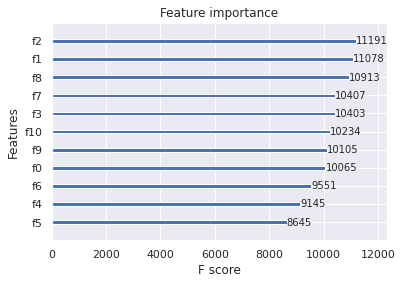

In [51]:
#Visalusing the F5 label encoded 'Electronic' music genre category
plot_importance(xgb)

In [52]:
y['genre_Category'].value_counts()

9    5000
8    5000
7    5000
6    5000
5    5000
4    5000
3    5000
2    5000
1    5000
0    5000
Name: genre_Category, dtype: int64

KNearestNeighbors

In [53]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_probs = knn.predict(X_test) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
knn_matrix = metrics.confusion_matrix(y_test, knn_probs)
knn_matrix

array([[404,  20,  38,   9, 174,  38,  90,  45,  58, 124],
       [ 48, 701,  70,  81,  37,  39,   0,  20,   2,   2],
       [ 79, 121, 480,  26, 130,  41,   5,  88,   3,  27],
       [ 22,  47,  25, 845,   8,  15,   0,  38,   0,   0],
       [168,  30,  86,   7, 470,  17,  27,  46,  24, 125],
       [ 94,  93,  69,  17,  74, 487,  38,  93,  20,  15],
       [ 72,   3,   3,   0,  28,   9, 442,   7, 382,  54],
       [ 80,  34, 127,  84, 100, 104,  35, 396,  10,  30],
       [104,   0,   4,   0,  34,  13, 466,   7, 289,  83],
       [241,   1,  32,   1, 147,  12,  59,  41,  69, 397]])

In [55]:
print("Accuracy:",metrics.accuracy_score(y_test, knn_probs))
print("Precision:",metrics.precision_score(y_test, knn_probs, average='micro'))
print("Recall:",metrics.recall_score(y_test, knn_probs, average='micro'))
print('F1 Score: ', f1_score(y_test, knn_probs, average= "micro"))

Accuracy: 0.4911
Precision: 0.4911
Recall: 0.4911
F1 Score:  0.4911


In [56]:
#kappa score integrates measurements of chance and class imbalance
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, clf_pred)
#The score here is moderate-low 

0.5256666666666667

The best performing model was the SVM with performace of an approx. 57%. The operated dataset showed less evidence of being imbalanced. The probability of music genre being correctly predicted according to our model is litle over 50 percent. Although these are not great odds, one can optimise further by selecting lesser features through high correlation, normalisation, shuffling the average parameter between micro, macro, weighted to balance weights.